In [2]:
#Author: Francesco Cirotto
from datetime import datetime
from datetime import time
from datetime import timedelta
import os,glob
import json
import time as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cycler import cycler
import itertools


In [3]:
def getCurrentDate():
    today=datetime.today()
    d2=today.strftime("%B %d,%Y")
    return d2

def getDF(path, skipFile = []):

    all_files =  [fn for fn in glob.glob(os.path.join(path, "*.csv")) if not fn in skipFile]
    print(all_files)
    
    df_from_each_file = (pd.read_csv(f) for f in all_files)
    concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
    return concatenated_df

In [4]:
#rearrange dataset
df = getDF('database/', ['database/db_2023_02_09.csv'])

df

['database/db_2022_07_28.csv', 'database/db_2022_12_22.csv', 'database/db_2023_03_04.csv', 'database/db_2022_09_07.csv', 'database/db_2022_09_28.csv', 'database/db_2023_09_11.csv', 'database/db_2023_07_12.csv', 'database/db_2023_02_20.csv', 'database/db_2023_02_11.csv', 'database/db_2023_05_31.csv', 'database/db_2023_09_19.csv', 'database/db_2022_06_28.csv', 'database/db_2022_06_10.csv', 'database/db_2023_02_03.csv', 'database/db_2022_07_18.csv', 'database/db_2023_04_03.csv']


Unnamed: 0        Analysis         Quota  Total Files        date  \
0            21     HLRS_solarb  35504.035279         5248  2022-07-28   
1            12         HH_bbVV  23728.014587        10588  2022-07-28   
2            10     HBSM_tautau  14070.514186        49705  2022-07-28   
3            20       HLRS_lily  11676.857304        10282  2022-07-28   
4            19       HLRS_ZdZd  10995.572497          114  2022-07-28   
..          ...             ...           ...          ...         ...   
471          22     HLRS_solart      0.000000            0  2023-04-03   
472          23  HLRS_ttXtautau      0.000000            0  2023-04-03   
473           5             DJR      0.000000            0  2023-04-03   
474           3             AZH      0.000000            0  2023-04-03   
475           2         ??_run2      0.000000            0  2023-04-03   

     expiring  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
471         0  
472         0  
473         0  
474         0  
475         0  

[476 rows x 6 columns]

In [9]:
%matplotlib inline

def makeGlobalPlots(df):
    allowed_quota = 3.0e5
    top_lim = allowed_quota*1.05
    
    dates = np.unique(df['date'].to_numpy())
    print(dates)
    
    quotas = [ df.loc[df['date'] == d]['Quota'].sum() for d in dates]
    tot_files = [df.loc[df['date'] == d]['Total Files'].sum() for d in dates]
    exps = [df.loc[df['date'] == d]['expiring'].sum() for d in dates]
    analyses = [df.loc[df['date'] == d]['Analysis'].count() for d in dates]
    c_analyses = [df.loc[(df['date'] == d )& (df['Quota'] > 0)]['Analysis'].count() for d in dates]
   
   
    #--------------------------------------------------------------------
    fig, (ax1,ax3) = plt.subplots(2,1,dpi=150,sharex=True)
    fig.suptitle('Tape Summary ' + '(' + getCurrentDate() + ')')

    #quota
    ax1.plot(dates,quotas)
    ax1.set_ylim(top = top_lim*1.1, bottom=np.amin(quotas)*0.95)
    #ax1.set_yscale('log')
    ax1.axhline(y=allowed_quota, color='r', linestyle='--')
    ax1.text(s='Group grid space quota ({} Tb)'.format(int(allowed_quota/1000)),y = top_lim,x=0,color='r')

    ax1.set_ylabel('Quota')
    ax1.tick_params(axis='x',rotation = 25)

    #ax1.text(0.5, 0.5, r'an equation: $E=mc^2$', fontsize=15)
    
    #total files and expiration files 
    ax3.plot(dates,tot_files,color='b')
    #ax3.set_xlabel('Date')
    ax3.set_ylabel('Files',color='b')
    ax3.tick_params(axis='y', labelcolor='b')
    ax3b = ax3.twinx() 
    ax3b.plot(dates,exps,color='r')
    ax3b.set_ylabel('Expiration Files',color='r')
    ax3b.tick_params(axis='y', labelcolor='r')
    ax3.tick_params(axis='x',rotation = 90)

    #plt.subplots_adjust(
    #                wspace=0.5, 
    #                hspace=1)
    fig.tight_layout()
    fig.savefig('QuotaSummary.png',bbox_inches='tight')
    #--------------------------------------

    fig2, (ax3) = plt.subplots(figsize=(5,3),dpi=150)
    fig2.suptitle('Tape Summary ' + '(' + getCurrentDate() + ')')

    
    #analysis in database and fraction of analysis with space
    labels = ['Total analyses in database','Analyses with space']
    ax3.bar(dates, analyses)
    ax3.bar(dates, c_analyses,color='tab:orange')
    ax3.set_ylim(bottom=0)
    ax3.legend(loc="upper right",labels=labels, bbox_to_anchor=(0.85, 1.35), fontsize=8)

    ax3.tick_params(axis='x',rotation = 90)
    fig2.savefig('AnalysisSummary.png',bbox_inches='tight')
   
    #pie chart
    #select latest date
    fig3, (ax4) = plt.subplots(figsize=(4,4),dpi=100)
    last = max(dates)
    a = df.loc[(df['date']==last) & (df['Quota']>0)][['Analysis', 'Quota']].to_numpy()
    #ascending sorting according column 1(quota)
    a = a[np.argsort(a[:,1])]
    a[:,1] = a[:,1]/np.sum(a[:,1]) #normalize quotas
    all_analyses = a[:,0]
    all_a_quotas = a[:,1]
    fraction=0.03
    x=np.where(all_a_quotas >fraction)
    merged_fraction = all_a_quotas[:min(x[0])].sum()
    a_quotas = np.append(all_a_quotas[x], merged_fraction)
    analyses_ = np.append(all_analyses[x], 'Others(<{}%)'.format(fraction*100))
    #ax4.pie(a_quotas, labels=analyses, autopct='%1.1f%%',
    #    shadow=False, startangle=90)
    #ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    wedges, texts = ax4.pie(a_quotas, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax4.annotate('{} {}%'.format(analyses_[i], round(a_quotas[i]*100, 1)), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

    fig3.savefig('PieSummary.png',bbox_inches='tight')
    

['2022-06-10' '2022-06-28' '2022-07-18' '2022-07-28' '2022-09-07'
 '2022-09-28' '2022-12-22' '2023-02-03' '2023-02-11' '2023-02-20'
 '2023-03-04' '2023-04-03' '2023-05-31' '2023-07-12' '2023-09-11'
 '2023-09-19']


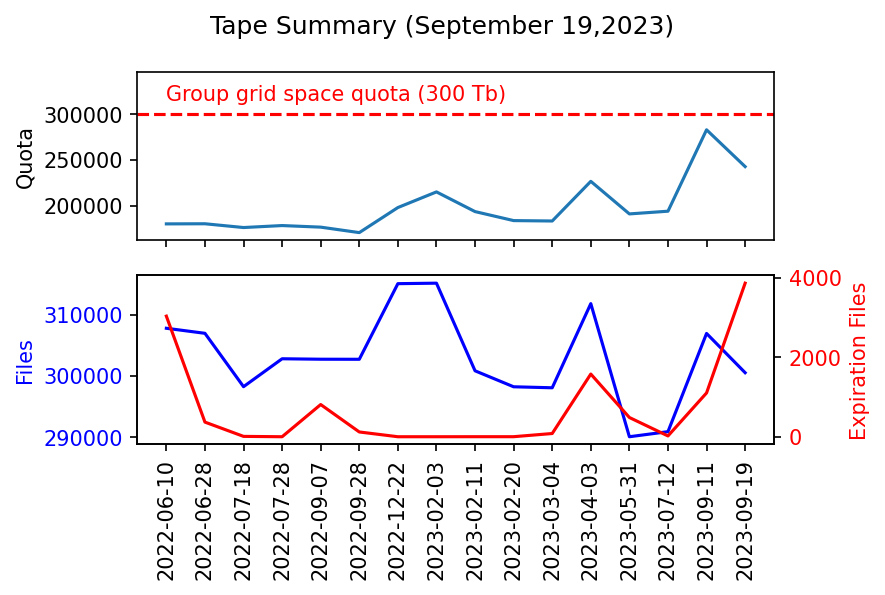

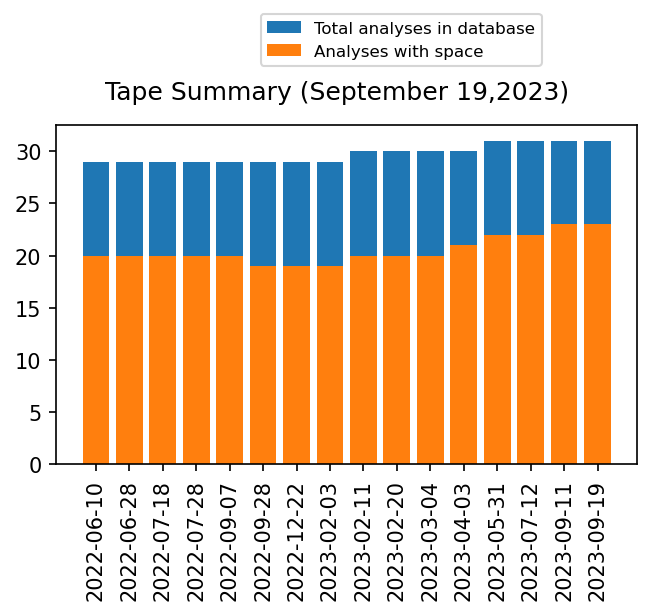

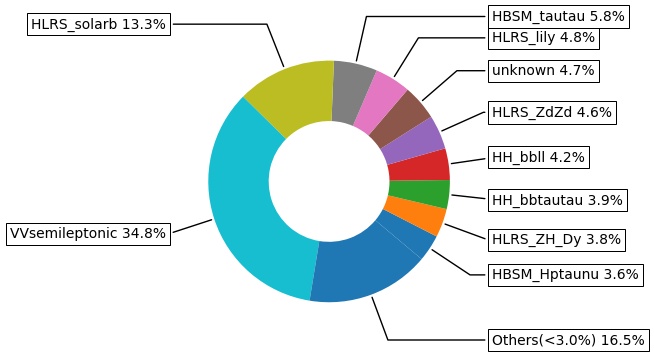

In [10]:
makeGlobalPlots(df)


In [11]:
#plot for info for each analysis
def makeSizePlot(yName,yAxis, df,log=True):
        

    
    #1. Order dataset in Quotas to latest date
    dates = np.unique(df['date'].to_numpy())
    max_dates = max(dates, key=lambda x: datetime.strptime(x, "%Y-%m-%d"))
    final_df = df.loc[df['date'] == max_dates].sort_values(by=['Quota'], ascending=False)
    ana = final_df['Analysis'].to_numpy() 
    
    #2. Check if there are analyses with Quota 0 in all dates
    
    analyses = np.array([a for a in ana if not (df.loc[df['Analysis'] == a]['Quota'] ==0).all() ])
    theAnalysis = np.array_split(analyses, 2)

   
    print(theAnalysis)
    print (final_df)
    #raise()
    
    
    #3. create a colormap
    color = iter(cm.rainbow(np.linspace(0, 1, len(analyses) )))
    marker = itertools.cycle(('v','s' , 'o','^', '*','X','D','P')) 
    #fig = plt.figure(figsize=(8,5))
    
    fig, axs = plt.subplots(2,1,dpi=200,figsize=(10,7),sharex=True)


    for i,a_ in enumerate(theAnalysis):
       
        for a in a_:
            #print(a)
          
            if '??' in a: 
                print ('skipping', a)
                continue
            c = next(color)
            '''
            Y = [ df.loc[ (df['Analysis']==a) & (df['date']==date)][yName] for date in dates]
            #print(Y)
           
            if not np.any(Y):
                print('skipping ',a, Y)
                continue
            #labels.append(a)

        
            axs[i].plot(dates,Y, c =c , marker=next(marker), label = a)
            '''
            
            the_var = []
            the_dates = []
            for date in dates:
                #does analysis exist in date?
                if ((df['Analysis'] == a) & (df['date']==date)).any(): 
                    the_dates.append(date)
                    the_var.append(df.loc[(df['Analysis'] == a) & (df['date']==date)][yName])
            if not np.any(np.array(the_var)):
                print('skpping ', a)               
                continue
                
           

           
            axs[i].plot(the_dates, the_var, c =c , marker=next(marker), label = a)
            
            axs[i].axhline(y=1e4, color='r', linestyle=':')
            axs[i].axhline(y=5e3, color='tab:orange', linestyle=':')

            axs[i].set_ylabel('Analysis Quota [Gb]')
            #axs[i].set_ylim(bottom=np.amin(the_var))
            
            #axs[i].set_xticklabels(axs[i].get_xticks(), rotation = 50)
    #axs[0].set_yscale('log')
    axs[1].tick_params(axis='x',rotation = 25)            
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels,loc='upper center',bbox_to_anchor=(0.5, 0), fontsize = 10, ncol=5)
    fig.suptitle("Analysis Quota" + '(' + getCurrentDate() + ')')
    #st.set_y(0.95)
    fig.savefig('AnalysisQuota.png',bbox_inches='tight')
   

[array(['VVsemileptonic', 'HLRS_solarb', 'HBSM_tautau', 'HLRS_lily',
       'unknown', 'HLRS_ZdZd', 'HH_bbll', 'HH_bbtautau', 'HLRS_ZH_Dy',
       'HBSM_Hptaunu', 'YXH', 'HH_ML'], dtype='<U14'), array(['DBL_ssWWWZ', 'HLRS_ttXuu', 'HBSM_bHbbb', 'HLRS_4tau', 'DBL_GHH',
       'HH_bbVV', 'HBSM_H+WH', 'ZdZd_2l2j', '??_Inv', '??_run2', 'VVJJ',
       'DJR'], dtype='<U14')]
     Unnamed: 0          Analysis         Quota  Total Files        date  \
299          27    VVsemileptonic  84424.621681        24277  2023-09-19   
300          22       HLRS_solarb  32178.276317         6036  2023-09-19   
301          11       HBSM_tautau  14109.247215        50031  2023-09-19   
302          21         HLRS_lily  11676.857304        10282  2023-09-19   
303          30           unknown  11519.753595         6503  2023-09-19   
304          20         HLRS_ZdZd  11083.232298          261  2023-09-19   
305          15           HH_bbll  10267.080591         3009  2023-09-19   
306          16      

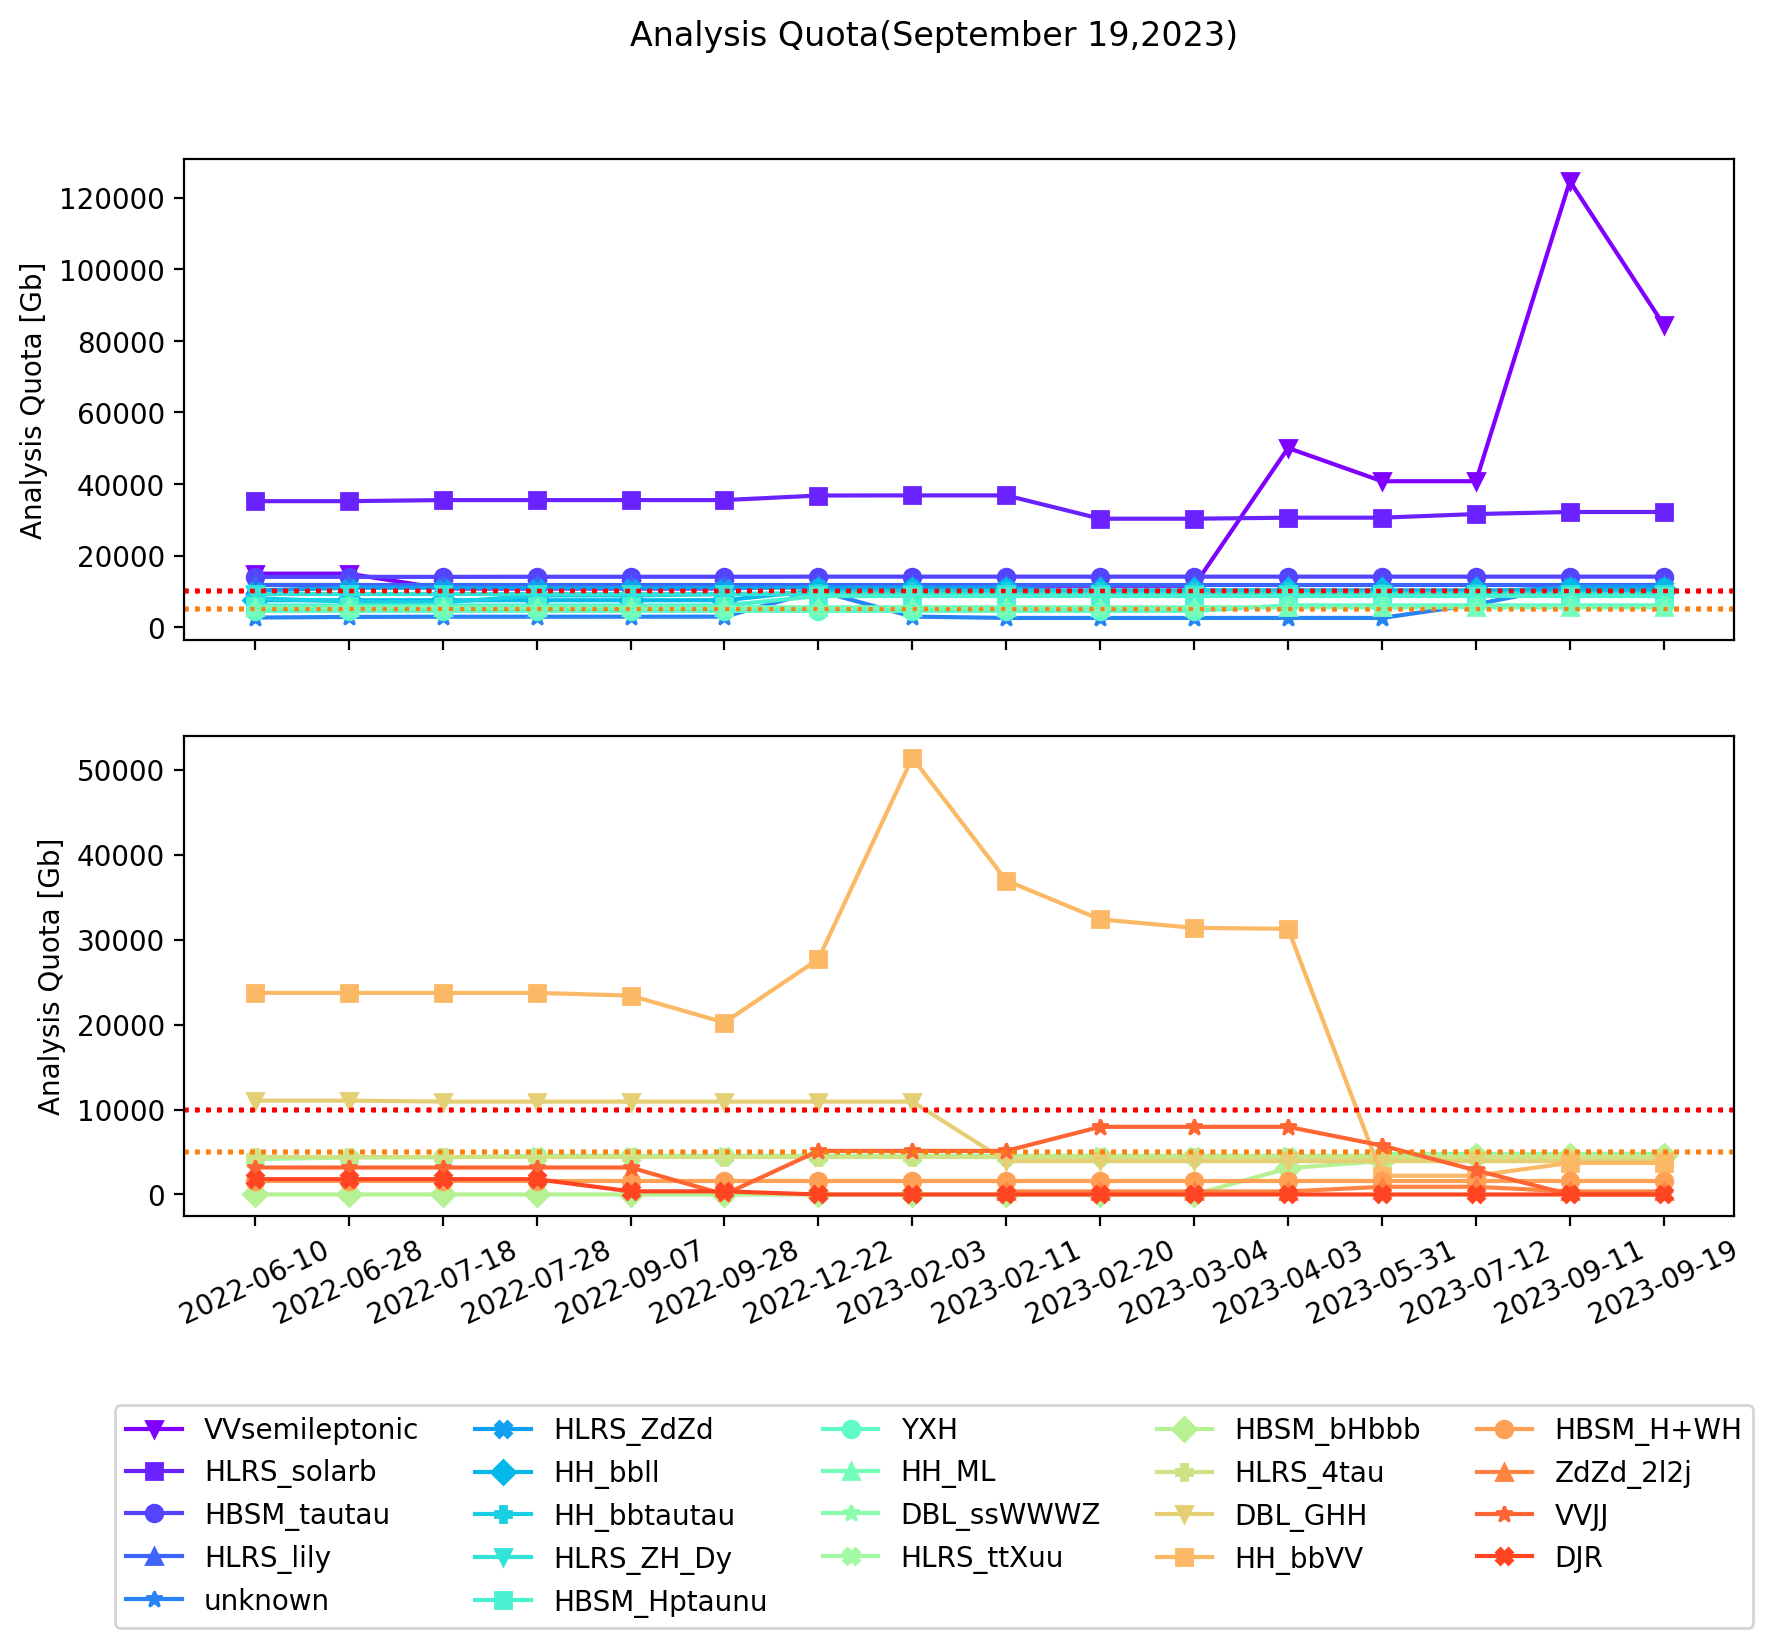

In [12]:
#analyses
makeSizePlot('Quota','Total Quota',df)